In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv
/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
his_df = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/historical_weather.csv')

In [4]:
his_df.tail(10)

city_id        date  avg_temp_c  min_temp_c  max_temp_c  \
182328    C112  2018-12-22        18.5        15.9        22.4   
182329    C112  2018-12-23        19.3        14.2        24.3   
182330    C112  2018-12-24        20.6        14.7        26.5   
182331    C112  2018-12-25        21.9        15.8        28.0   
182332    C112  2018-12-26        22.3        16.7        28.6   
182333    C112  2018-12-27        22.0        15.9        27.9   
182334    C112  2018-12-28        21.9        14.9        28.2   
182335    C112  2018-12-29        22.4        16.3        28.2   
182336    C112  2018-12-30        21.6        18.5        26.6   
182337    C112  2018-12-31        20.2        17.1        25.0   

        precipitation_mm  snow_depth_mm  avg_wind_dir_deg  avg_wind_speed_kmh  
182328               1.7            NaN             137.0                18.4  
182329               0.2            NaN             122.0                10.7  
182330               0.0            NaN              28.0                 8.8  
182331               0.0            NaN              36.0                 9.9  
182332               0.0            NaN              68.0                11.4  
182333               0.0            NaN             100.0                13.2  
182334               0.0            NaN              91.0                12.6  
182335               0.0            NaN              61.0                14.2  
182336               1.6            NaN              70.0                17.0  
182337              17.5            NaN             103.0                12.6

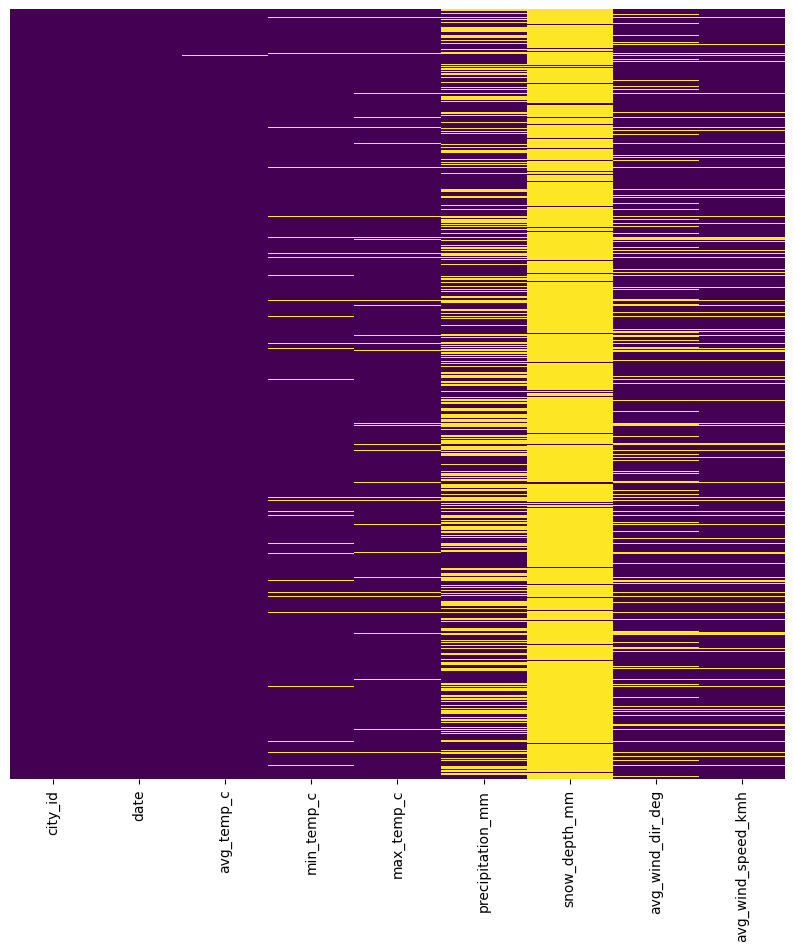

In [5]:
plt.figure(figsize = (10,10))
sns.heatmap(his_df.sample(n = 10000, random_state = 1).isnull(), cmap  = 'viridis', cbar = False, yticklabels = False,
            # xticklabels= False
            )
plt.show()

In [6]:
column_names=['avg_temp_c','min_temp_c','max_temp_c','precipitation_mm','snow_depth_mm','avg_wind_dir_deg','avg_wind_speed_kmh']
for column_name in column_names:
    nan_percentage = his_df[column_name].isna().mean() * 100
    print(f"The percentage of NaN values in '{column_name}' is {nan_percentage:.2f}%")

The percentage of NaN values in 'avg_temp_c' is 0.67%
The percentage of NaN values in 'min_temp_c' is 3.23%
The percentage of NaN values in 'max_temp_c' is 4.11%
The percentage of NaN values in 'precipitation_mm' is 38.25%
The percentage of NaN values in 'snow_depth_mm' is 93.29%
The percentage of NaN values in 'avg_wind_dir_deg' is 19.41%
The percentage of NaN values in 'avg_wind_speed_kmh' is 12.32%


In [7]:
min_ = his_df['snow_depth_mm'].min()
print(f"The minimum snow_depth_mm is {min_}")

max_ = his_df['snow_depth_mm'].max()
print(f"The maximum snow_depth_mm is {max_}")

The minimum snow_depth_mm is 0.0
The maximum snow_depth_mm is 7140.0


In [8]:
zero_count = (his_df['snow_depth_mm'] == 0).sum()
print(f"The number of zero values in snow_depth_mmis {zero_count}")

total_count = his_df['snow_depth_mm'] .count()
# Compute the percentage
zero_percentage = (zero_count / total_count) * 100

print(f"The percentage of zero values in 'age' is {zero_percentage:.2f}%")

The number of zero values in snow_depth_mmis 4621
The percentage of zero values in 'age' is 37.76%


In [ ]:
#his_df['snow_depth_mm'] = his_df['snow_depth_mm'].fillna(0)

**snow_depth_mm** should be removed and others should be checked further

In [9]:
his_df = his_df.drop(columns=['snow_depth_mm'])

In [10]:
his_df.dtypes

city_id                object
date                   object
avg_temp_c            float64
min_temp_c            float64
max_temp_c            float64
precipitation_mm      float64
avg_wind_dir_deg      float64
avg_wind_speed_kmh    float64
dtype: object

In [11]:
his_df['date'] = pd.to_datetime(his_df['date'])

In [ ]:
# his_df['year'] = his_df['date'].dt.year
# his_df['month'] = his_df['date'].dt.month
# his_df['day'] = his_df['date'].dt.day

In [ ]:
# his_df=his_df.drop(columns=['date'])

In [12]:
his_df.columns

Index(['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh'],
      dtype='object')

In [13]:
his_df['city_id'].unique()

array(['C001', 'C002', 'C003', 'C004', 'C005', 'C007', 'C008', 'C009',
       'C010', 'C011', 'C012', 'C013', 'C014', 'C015', 'C016', 'C017',
       'C018', 'C020', 'C022', 'C023', 'C024', 'C025', 'C027', 'C028',
       'C029', 'C030', 'C031', 'C033', 'C034', 'C035', 'C036', 'C037',
       'C038', 'C039', 'C040', 'C042', 'C043', 'C044', 'C045', 'C046',
       'C047', 'C048', 'C049', 'C051', 'C053', 'C054', 'C055', 'C056',
       'C057', 'C058', 'C059', 'C061', 'C062', 'C064', 'C065', 'C066',
       'C067', 'C068', 'C069', 'C070', 'C071', 'C072', 'C073', 'C074',
       'C076', 'C077', 'C078', 'C079', 'C081', 'C082', 'C083', 'C084',
       'C085', 'C086', 'C087', 'C088', 'C089', 'C090', 'C091', 'C092',
       'C093', 'C094', 'C095', 'C096', 'C097', 'C098', 'C099', 'C100',
       'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108',
       'C109', 'C110', 'C111', 'C112'], dtype=object)

In [14]:
metric_df=his_df.drop(columns=['city_id', 'date'])

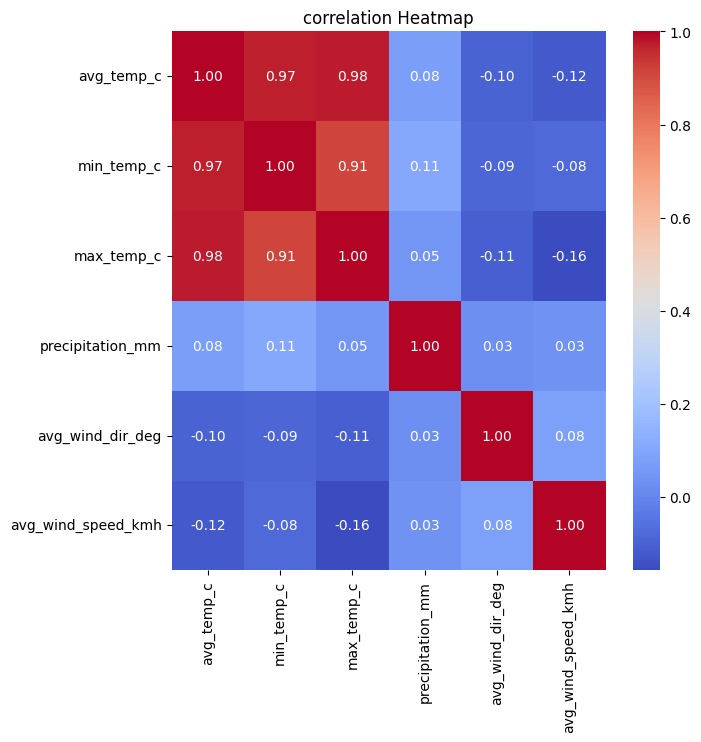

In [15]:
correlation_matrix = metric_df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(correlation_matrix, annot = True, cmap='coolwarm',fmt=".2f")
plt.title("correlation Heatmap")
plt.show()

In [16]:
his_df=his_df.drop(columns=['min_temp_c','max_temp_c'])

In [17]:
his_df.columns

Index(['city_id', 'date', 'avg_temp_c', 'precipitation_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh'],
      dtype='object')

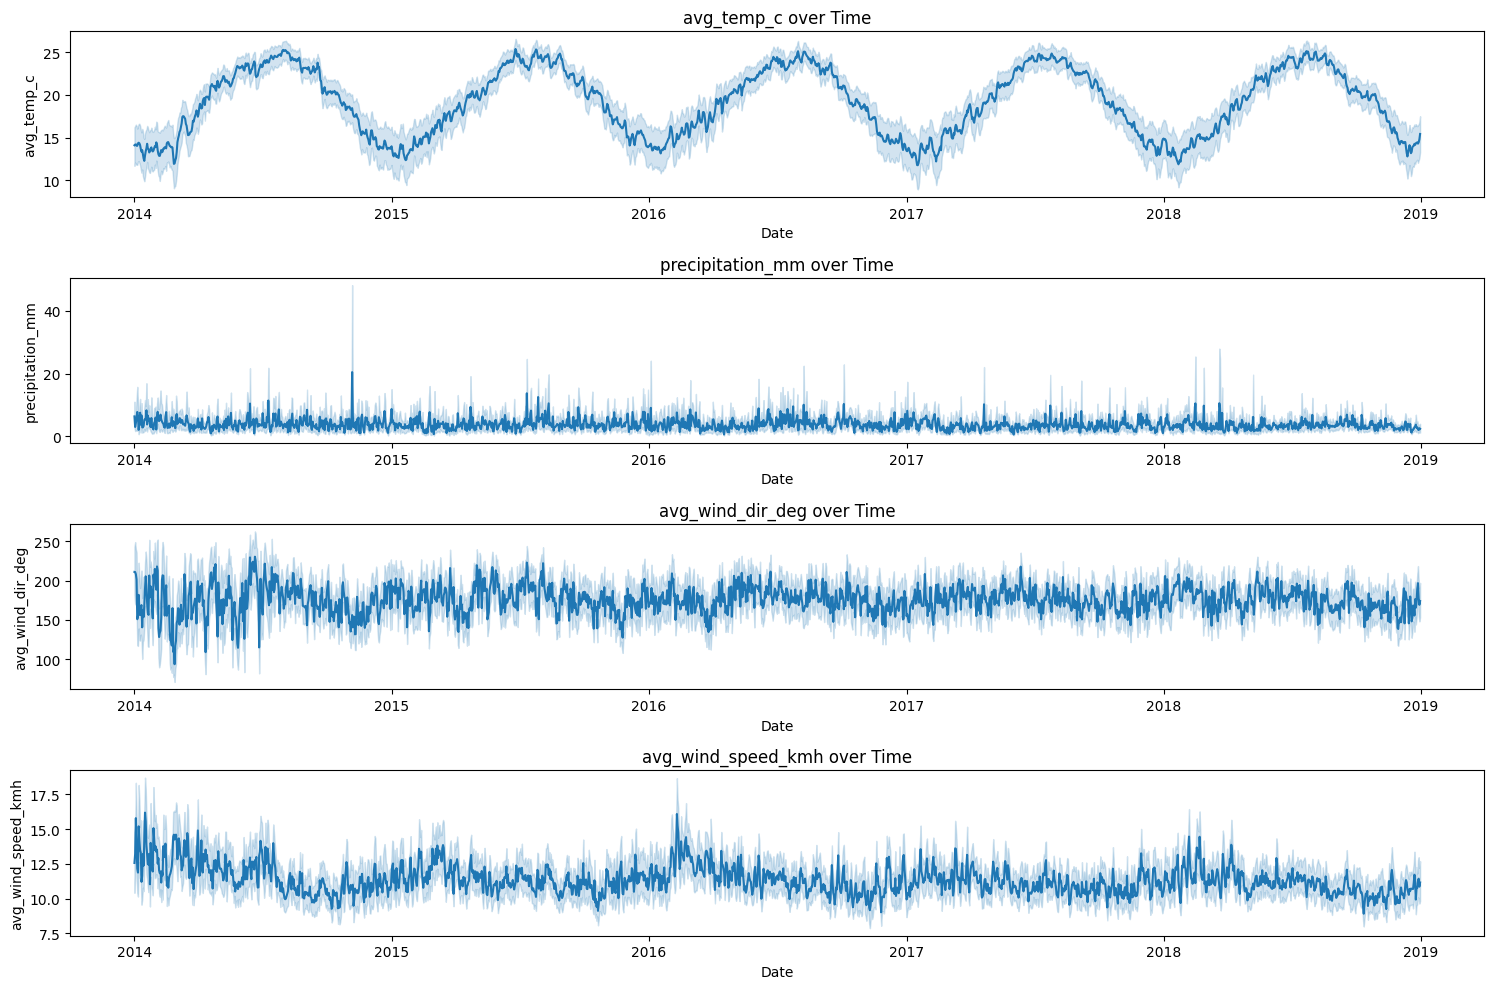

In [137]:
# Select features for plotting
features = ['avg_temp_c', 'precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh']

# Plot the distribution of each variable over time
plt.figure(figsize=(15, 10))
for i, feature in enumerate(features, 1):
    plt.subplot(len(features), 1, i)
    sns.lineplot(data=his_df, x='date', y=feature)
    plt.title(f'{feature} over Time')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.tight_layout()

plt.show()

Note - Average temp shows a clear seasonal variation than others, therefore its better to use that directly for the prediction

In [139]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

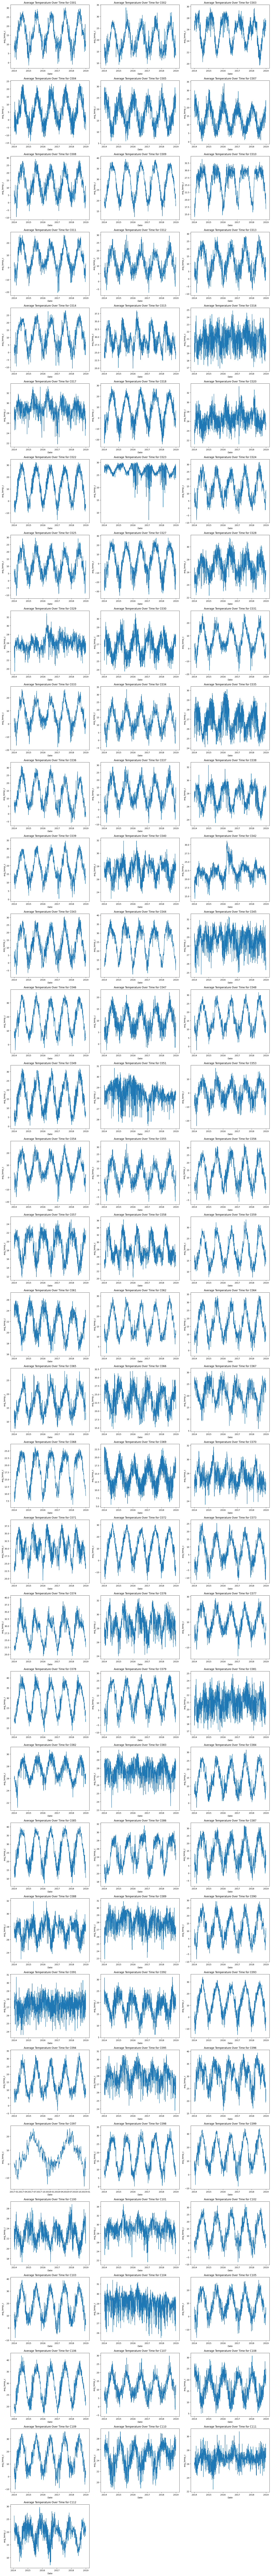

In [140]:
# Unique cities
cities = his_df['city_id'].unique()

# Calculate the number of rows for the subplot grid
n_cities = len(cities)
n_rows = (n_cities + 2) // 3  # 3 plots per row

# Plot avg_temp_c over time for each city
plt.figure(figsize=(18, n_rows * 5))
for i, city in enumerate(cities, 1):
    plt.subplot(n_rows, 3, i)
    city_data = his_df[his_df['city_id'] == city]
    sns.lineplot(data=city_data, x='date', y='avg_temp_c')
    plt.title(f'Average Temperature Over Time for {city}')
    plt.xlabel('Date')
    plt.ylabel('avg_temp_c')

plt.tight_layout()
plt.show()

note- therefore we need seasonal models, rather than simpler nes like moving averages

In [18]:
his_df.columns

Index(['city_id', 'date', 'avg_temp_c', 'precipitation_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh'],
      dtype='object')

In [19]:
df=his_df.drop(columns=['precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh'])

In [20]:
df.tail(5)

city_id       date  avg_temp_c
182333    C112 2018-12-27        22.0
182334    C112 2018-12-28        21.9
182335    C112 2018-12-29        22.4
182336    C112 2018-12-30        21.6
182337    C112 2018-12-31        20.2

In [21]:
train = df[(df['date'] >= '2014-01-01') & (df['date'] < '2018-01-01')]
val = df[(df['date'] >= '2018-01-01') & (df['date'] < '2018-01-08')]

In [22]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

city = 'C001' # sample city that concidered
city_data = train[train['city_id'] == city][['date', 'avg_temp_c']]
city_val = val[val['city_id'] == city][['date', 'avg_temp_c']] 

In [23]:
city_val.tail(7)

date  avg_temp_c
1461 2018-01-01         8.1
1462 2018-01-02         8.5
1463 2018-01-03         9.6
1464 2018-01-04        11.8
1465 2018-01-05        11.6
1466 2018-01-06        12.6
1467 2018-01-07        10.3

08:18:50 - cmdstanpy - INFO - Chain [1] start processing
08:18:50 - cmdstanpy - INFO - Chain [1] done processing


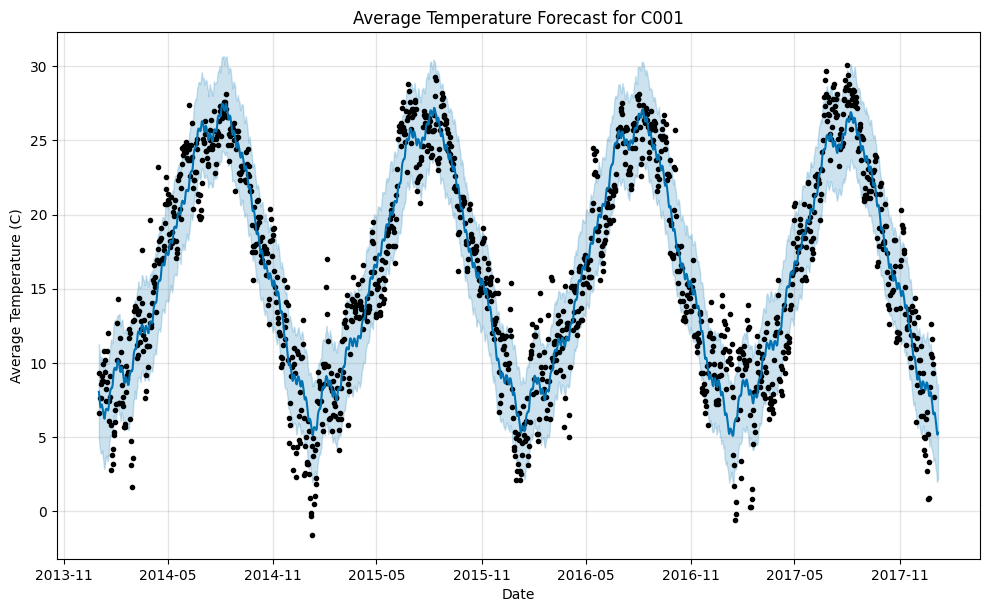

ds      yhat  yhat_lower  yhat_upper
1461 2018-01-01  6.642039    3.553444    9.762762
1462 2018-01-02  6.433668    3.178757    9.558844
1463 2018-01-03  6.112968    2.822631    9.138924
1464 2018-01-04  5.770610    2.660527    9.047063
1465 2018-01-05  5.350831    1.962226    8.337061
1466 2018-01-06  5.147733    2.062417    8.193488
1467 2018-01-07  5.295807    2.184779    8.561829

In [148]:
# Rename columns for Prophet
city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'}, inplace=True)

# Initialize Prophet model
model = Prophet()

# Fit the model
model.fit(city_data)

# Make a DataFrame with future dates for the next week
future_dates = model.make_future_dataframe(periods=7)

# Make predictions
forecast = model.predict(future_dates)

# Plot the forecast
fig = model.plot(forecast)
plt.title(f'Average Temperature Forecast for {city}')
plt.xlabel('Date')
plt.ylabel('Average Temperature (C)')
plt.show()

# Display forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

In [149]:
# Assuming y_true contains the actual observed values
y_true = city_val['avg_temp_c'].values[-7:]  # Actual values for the last 7 days
y_pred = forecast['yhat'].values[-7:]  # Predicted values for the last 7 days
y_pred_low = forecast['yhat_lower'].values[-7:]
y_pred_upp = forecast['yhat_upper'].values[-7:]

# Calculate MAE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse_low = np.sqrt(mean_squared_error(y_true, y_pred_low))
rmse_upp = np.sqrt(mean_squared_error(y_true, y_pred_upp))
print("Root Mean Squared Error (RMSE) with y-hat:", rmse)
print("Root Mean Squared Error (RMSE) with y-hat-lower:", rmse_low)
print("Root Mean Squared Error (RMSE) with y-hat-upper:", rmse_upp)

Root Mean Squared Error (RMSE) with y-hat: 4.993405020718105
Root Mean Squared Error (RMSE) with y-hat-lower: 8.002085902924113
Root Mean Squared Error (RMSE) with y-hat-upper: 2.5287641744362546


For each city, predict the the value of first 7 days, and decide whether to choose mae, mae_lower or mae_upper for the next year predictions

In [24]:
cities = his_df['city_id'].unique()

In [25]:
# Create a dictionary with city IDs as keys and indices as values
city_dict_err = {city: index for index, city in enumerate(cities)}
city_dict_model = {city: index for index, city in enumerate(cities)}

# Print the dictionary
print(city_dict_err)

{'C001': 0, 'C002': 1, 'C003': 2, 'C004': 3, 'C005': 4, 'C007': 5, 'C008': 6, 'C009': 7, 'C010': 8, 'C011': 9, 'C012': 10, 'C013': 11, 'C014': 12, 'C015': 13, 'C016': 14, 'C017': 15, 'C018': 16, 'C020': 17, 'C022': 18, 'C023': 19, 'C024': 20, 'C025': 21, 'C027': 22, 'C028': 23, 'C029': 24, 'C030': 25, 'C031': 26, 'C033': 27, 'C034': 28, 'C035': 29, 'C036': 30, 'C037': 31, 'C038': 32, 'C039': 33, 'C040': 34, 'C042': 35, 'C043': 36, 'C044': 37, 'C045': 38, 'C046': 39, 'C047': 40, 'C048': 41, 'C049': 42, 'C051': 43, 'C053': 44, 'C054': 45, 'C055': 46, 'C056': 47, 'C057': 48, 'C058': 49, 'C059': 50, 'C061': 51, 'C062': 52, 'C064': 53, 'C065': 54, 'C066': 55, 'C067': 56, 'C068': 57, 'C069': 58, 'C070': 59, 'C071': 60, 'C072': 61, 'C073': 62, 'C074': 63, 'C076': 64, 'C077': 65, 'C078': 66, 'C079': 67, 'C081': 68, 'C082': 69, 'C083': 70, 'C084': 71, 'C085': 72, 'C086': 73, 'C087': 74, 'C088': 75, 'C089': 76, 'C090': 77, 'C091': 78, 'C092': 79, 'C093': 80, 'C094': 81, 'C095': 82, 'C096': 83, '

In [152]:
city_dict['C001']

0

In [153]:
err=0
count=0

for city in cities:
    city_data = train[train['city_id'] == city][['date', 'avg_temp_c']]
    city_val = val[val['city_id'] == city][['date', 'avg_temp_c']] 

    # Rename columns for Prophet
    city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'}, inplace=True)

    # Initialize Prophet model
    model = Prophet()

    # Fit the model
    model.fit(city_data)

    # Make a DataFrame with future dates for the next week
    future_dates = model.make_future_dataframe(periods=7)

    # Make predictions
    forecast = model.predict(future_dates)

    # # Plot the forecast
    # fig = model.plot(forecast)
    # plt.title(f'Average Temperature Forecast for {city}')
    # plt.xlabel('Date')
    # plt.ylabel('Average Temperature (C)')
    # plt.show()

    # Display forecasted values
    #forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

    # Assuming y_true contains the actual observed values
    y_true = city_val['avg_temp_c'].values[-7:]  # Actual values for the last 7 days
    y_pred = forecast['yhat'].values[-7:]  # Predicted values for the last 7 days
    y_pred_low = forecast['yhat_lower'].values[-7:]
    y_pred_upp = forecast['yhat_upper'].values[-7:]

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmse_low = np.sqrt(mean_squared_error(y_true, y_pred_low))
    rmse_upp = np.sqrt(mean_squared_error(y_true, y_pred_upp))


    min_rmse = min(rmse, rmse_low, rmse_upp)

    # Determine which variable has the lowest value
    if min_rmse == rmse:
        lowest_name = 'yhat'
    elif min_rmse == rmse_low:
        lowest_name = 'yhat_lower'
    else:
        lowest_name = 'yhat_upper'

    city_dict_err[city]=lowest_name
    city_dict_model[city]=model
    err+=min_rmse
    count+=1

08:19:26 - cmdstanpy - INFO - Chain [1] start processing
08:19:26 - cmdstanpy - INFO - Chain [1] done processing
08:19:27 - cmdstanpy - INFO - Chain [1] start processing
08:19:27 - cmdstanpy - INFO - Chain [1] done processing
08:19:28 - cmdstanpy - INFO - Chain [1] start processing
08:19:28 - cmdstanpy - INFO - Chain [1] done processing
08:19:30 - cmdstanpy - INFO - Chain [1] start processing
08:19:30 - cmdstanpy - INFO - Chain [1] done processing
08:19:31 - cmdstanpy - INFO - Chain [1] start processing
08:19:31 - cmdstanpy - INFO - Chain [1] done processing
08:19:32 - cmdstanpy - INFO - Chain [1] start processing
08:19:32 - cmdstanpy - INFO - Chain [1] done processing
08:19:33 - cmdstanpy - INFO - Chain [1] start processing
08:19:33 - cmdstanpy - INFO - Chain [1] done processing
08:19:34 - cmdstanpy - INFO - Chain [1] start processing
08:19:34 - cmdstanpy - INFO - Chain [1] done processing
08:19:35 - cmdstanpy - INFO - Chain [1] start processing
08:19:35 - cmdstanpy - INFO - Chain [1]

In [154]:
    avg_err = err / count
    print(avg_err)

1.9884398758534771


now need to predict the first 7 days, using those saved model and the lowest_name s

**Predicitng part**

In [26]:
sub_df = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/submission_key.csv')

In [27]:
sub_df.dtypes

submission_ID     int64
city_id          object
date             object
dtype: object

In [28]:
sub_df['date'] = pd.to_datetime(sub_df['date'])

In [29]:
sub_df.dtypes

submission_ID             int64
city_id                  object
date             datetime64[ns]
dtype: object

In [30]:
sub_df.head(5)

submission_ID city_id       date
0              1    C001 2019-01-01
1              2    C001 2019-01-02
2              3    C001 2019-01-03
3              4    C001 2019-01-04
4              5    C001 2019-01-05

In [31]:
submission_P201 = pd.read_csv('/kaggle/input/predicta-1-0-predict-the-unpredictable/sample_submission.csv')

In [32]:
train = df[(df['date'] >= '2014-01-01') & (df['date'] < '2019-01-01')]

In [33]:
new_city_dict_model = {city: index for index, city in enumerate(cities)}

In [164]:
for city in cities:
    city_data = train[train['city_id'] == city][['date', 'avg_temp_c']]
    #city_val = val[val['city_id'] == city][['date', 'avg_temp_c']] 

    # Rename columns for Prophet
    city_data.rename(columns={'date': 'ds', 'avg_temp_c': 'y'}, inplace=True)

    # Initialize Prophet model
    model = Prophet()

    # Fit the model
    model.fit(city_data)

    # Make a DataFrame with future dates for the next week
    future_dates = model.make_future_dataframe(periods=7)

    # Make predictions
    #forecast = model.predict(future_dates)
    new_city_dict_model[city]=model

08:22:23 - cmdstanpy - INFO - Chain [1] start processing
08:22:23 - cmdstanpy - INFO - Chain [1] done processing
08:22:23 - cmdstanpy - INFO - Chain [1] start processing
08:22:24 - cmdstanpy - INFO - Chain [1] done processing
08:22:24 - cmdstanpy - INFO - Chain [1] start processing
08:22:24 - cmdstanpy - INFO - Chain [1] done processing
08:22:25 - cmdstanpy - INFO - Chain [1] start processing
08:22:25 - cmdstanpy - INFO - Chain [1] done processing
08:22:25 - cmdstanpy - INFO - Chain [1] start processing
08:22:25 - cmdstanpy - INFO - Chain [1] done processing
08:22:25 - cmdstanpy - INFO - Chain [1] start processing
08:22:26 - cmdstanpy - INFO - Chain [1] done processing
08:22:26 - cmdstanpy - INFO - Chain [1] start processing
08:22:26 - cmdstanpy - INFO - Chain [1] done processing
08:22:26 - cmdstanpy - INFO - Chain [1] start processing
08:22:26 - cmdstanpy - INFO - Chain [1] done processing
08:22:27 - cmdstanpy - INFO - Chain [1] start processing
08:22:27 - cmdstanpy - INFO - Chain [1]

In [171]:
for index, row in sub_df.iterrows():
    # Access elements of each row using column names
    #print(row['city_id'])
    city_model=new_city_dict_model[row['city_id']] #select the model
    
    future_date = pd.DataFrame({'ds': [row['date']]})

    # Use the trained model to make a prediction for the specific date
    forecast_specific_date = city_model.predict(future_date)
    #print(forecast_specific_date)
    predicted_value = forecast_specific_date[ 'yhat'].values[0] #city_dict_err[city]].values[0]

    submission_P201.loc[index, 'avg_temp_c'] = predicted_value
    
    submission_id_df1 = sub_df.at[index, 'submission_ID']
    submission_id_df2 = submission_P201.at[index, 'submission_ID']

    # Compare the submission_id values
    if not submission_id_df1 == submission_id_df2:
        print("submission_id is not equal on the row with index", known_index)

In [34]:
submission_P201.tail(10)

submission_ID  avg_temp_c
690            691         NaN
691            692         NaN
692            693         NaN
693            694         NaN
694            695         NaN
695            696         NaN
696            697         NaN
697            698         NaN
698            699         NaN
699            700         NaN

In [173]:
submission_P201.to_csv('submission.csv', index=False)

**SARIMA**

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [36]:
# Dictionary to store the models for each city
new_city_sarima_model = {}

# List of cities
cities = df['city_id'].unique()

for city in cities:
    city_data = train[train['city_id'] == city][['date', 'avg_temp_c']]

    # Prepare the data
    city_data.set_index('date', inplace=True)
    city_data.index = pd.to_datetime(city_data.index)
    city_data = city_data.asfreq('D')

    # Initialize and fit SARIMA model
    model = SARIMAX(city_data['avg_temp_c'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)

    # Make predictions for the next week
    forecast = model_fit.get_forecast(steps=7)
    forecast_index = pd.date_range(start=city_data.index[-1] + pd.Timedelta(days=1), periods=7, freq='D')
    forecast_values = forecast.predicted_mean
    forecast_ci = forecast.conf_int()

    # Store the model
    new_city_sarima_model[city] = model_fit

    # Print the forecast
    print(f"Forecast for {city}:")
#     print(forecast_values)
#     print(f"Confidence Interval:\n{forecast_ci}")


Forecast for C001:
Forecast for C002:
Forecast for C003:
Forecast for C004:
Forecast for C005:
Forecast for C007:
Forecast for C008:
Forecast for C009:
Forecast for C010:
Forecast for C011:
Forecast for C012:
Forecast for C013:
Forecast for C014:
Forecast for C015:
Forecast for C016:
Forecast for C017:
Forecast for C018:
Forecast for C020:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C022:
Forecast for C023:
Forecast for C024:
Forecast for C025:
Forecast for C027:
Forecast for C028:
Forecast for C029:
Forecast for C030:
Forecast for C031:
Forecast for C033:
Forecast for C034:
Forecast for C035:
Forecast for C036:
Forecast for C037:
Forecast for C038:
Forecast for C039:
Forecast for C040:
Forecast for C042:
Forecast for C043:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C044:
Forecast for C045:
Forecast for C046:
Forecast for C047:
Forecast for C048:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C049:
Forecast for C051:
Forecast for C053:
Forecast for C054:
Forecast for C055:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C056:
Forecast for C057:
Forecast for C058:
Forecast for C059:
Forecast for C061:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C062:
Forecast for C064:
Forecast for C065:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C066:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C067:
Forecast for C068:
Forecast for C069:
Forecast for C070:
Forecast for C071:
Forecast for C072:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C073:
Forecast for C074:
Forecast for C076:
Forecast for C077:
Forecast for C078:
Forecast for C079:
Forecast for C081:
Forecast for C082:
Forecast for C083:
Forecast for C084:
Forecast for C085:
Forecast for C086:
Forecast for C087:
Forecast for C088:
Forecast for C089:
Forecast for C090:
Forecast for C091:
Forecast for C092:
Forecast for C093:
Forecast for C094:
Forecast for C095:
Forecast for C096:
Forecast for C097:
Forecast for C098:
Forecast for C099:
Forecast for C100:


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Forecast for C101:
Forecast for C102:
Forecast for C103:
Forecast for C104:
Forecast for C105:
Forecast for C106:
Forecast for C107:
Forecast for C108:
Forecast for C109:
Forecast for C110:
Forecast for C111:
Forecast for C112:


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [40]:
type(forecast_values)

pandas.core.series.Series

In [41]:
forecast_values

2019-01-01    20.617311
2019-01-02    20.556479
2019-01-03    20.573672
2019-01-04    20.930732
2019-01-05    20.790953
2019-01-06    20.871404
2019-01-07    21.042618
Freq: D, Name: predicted_mean, dtype: float64

In [42]:
for index, row in sub_df.iterrows():
    city_id = row['city_id']
    prediction_date = pd.to_datetime(row['date'])

    # Select the SARIMA model for the specific city
    
    city_model = new_city_sarima_model[city_id]
    
    last_train_date = pd.to_datetime("2018-12-31")
    forecast_steps = (prediction_date - last_train_date).days

    
    forecast = city_model.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    predicted_value = forecast_mean.loc[prediction_date]

    # Update the submission DataFrame with the predicted value
    submission_P201.loc[index, 'avg_temp_c'] = predicted_value

    # Compare the submission_id values between the two DataFrames
    submission_id_df1 = sub_df.at[index, 'submission_ID']
    submission_id_df2 = submission_P201.at[index, 'submission_ID']

    if submission_id_df1 != submission_id_df2:
        print("submission_id is not equal on the row with index", index)

In [44]:
submission_P201.tail(5)

submission_ID  avg_temp_c
695            696   20.573672
696            697   20.930732
697            698   20.790953
698            699   20.871404
699            700   21.042618

In [45]:
submission_P201.to_csv('submission_P201_new.csv', index=False)